# Gravitational N-body systems (Solar System)
In this example the masses of the planets up to jupyter are obtained from their trajectories taken from the NASA Horizons project. (https://ssd.jpl.nasa.gov/horizons/app.html#/)

In [1]:
# Because this very small model doesn't profit from parallelization on GPU's, it can be faster to run it on CPU instead.
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import numpy as np
import scipy

from jax import jit
import jax.numpy as jnp

import matplotlib.pyplot as plt

from adoptODE import dataset_adoptODE, train_adoptODE

G_KM_MJ_D = 2.825e-7 # Newtons gravitational constant, with respect to kilometers, jupiter masses and days

In [3]:
# Defining the Equation of Motion:
def define_n_body(**kwargs):
    def gen_params():
        return {'masses_exp_10':scipy.stats.truncnorm.rvs(0,1, size=kwargs['N_bodies'])}, {}, {}

    def gen_y0():
        return {'positions':scipy.stats.truncnorm.rvs(-0.1,0.1, size=3*kwargs['N_bodies']).reshape((-1,3)), 'velocities':1e-4*scipy.stats.truncnorm.rvs(-5,5, size=3*kwargs['N_bodies']).reshape((-1,3))}

    @jit
    def eom(y,t,params, iparams, exparams):
        valid = 1-np.eye(kwargs['N_bodies'])
        dist_vecs = jnp.where(valid[:,:,jnp.newaxis]==1, (y['positions'] - y['positions'][:, jnp.newaxis]), jnp.ones_like(y['positions']))
        dists = jnp.linalg.norm(dist_vecs, axis=2)
        unit_dist_vecs = dist_vecs/dists[:,:,jnp.newaxis]
        dists = jnp.clip(dists, 1e-3, jnp.inf) # Avoid instability if bodies are very close together, e.g. by chance in random initial conditions
        masses = 10**params['masses_exp_10']
        acc = G_KM_MJ_D*valid[:,:,jnp.newaxis]*unit_dist_vecs * masses[jnp.newaxis,:, jnp.newaxis] / (dists[:,:,jnp.newaxis])**2
        total_acc = jnp.sum(acc, axis=1)
        return {'positions': y['velocities'], 'velocities':total_acc}

    @jit
    def loss(ys, params, iparams, exparams, ys_targets):
        loss_trajectory = jnp.sum((ys['positions']-jnp.nan_to_num(ys_targets['positions']))**2)+jnp.sum((ys['velocities']-jnp.nan_to_num(ys_targets['velocities']))**2)
        return loss_trajectory

    return eom, loss, gen_params, gen_y0, {}
    

In [4]:
# Loading prepared trajectories
path = '../data/SolarSystem/' # Contains Sun, Mercury, Venus, Earth, Mars, Jupiter, Saturn, Apophis, Eres (in this order)
coords = np.load(path+'Coordinates.npy')
vels = np.load(path+'Velocities.npy')
t_evals_data = np.load(path+'Times.npy')
ys_from_data = {'positions':coords, 'velocities':vels}
# The masses a measured in Jupiter masses, and the parameters are the logarithms with base 10 of the masses
true_params = {'masses_exp_10':np.log10([1047.5, 1.74e-4, 2.56e-3,3.15e-3,3.38e-4, 1, 2.99e-1, 1e-6, 1e-6])}

In [5]:
# Preparing dataset
N_sys = 1
# For imperfect masses, trajectories will diverge quickly from the true solution. 
# Hence we use a small value of the reset parameter in order to always look at the derivation of over a small period of time.
# Later, after the parameters have been optimized, it is possible to increase this parameter for higher accuracy. As one timestep
# corresponds to 20 days, this means we reset to a new starting value every 600 days, roughly 7 orbits of mercury.
reset_every = 30
kwargs_sys = {'N_sys':N_sys, 'N_bodies':ys_from_data['positions'].shape[2]}
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals_data)-1)/reset_every)))])

initial_guess_params = {'masses_exp_10':np.array([3.0,-4,-4,-4,-4,0,0,-6,-6])}
upper_params_boundary = {'masses_exp_10':np.array([4, 4, 4, 4, 4, 4, 4, -6, -6])}
lower_params_boundary = {'masses_exp_10':np.array([-4, -4, -4, -4, -4,-4,-4, -6, -6])}

kwargs_adoptODE = {'lr':0.03, 'epochs':100, 't_reset_idcs':t_reset_idcs, 'atol':1e-6, 'rtol':1e-6, 'upper_b':upper_params_boundary, 'lower_b':lower_params_boundary}
dataset_data = dataset_adoptODE(define_n_body, ys_from_data, t_evals_data, kwargs_sys, kwargs_adoptODE, params_train=initial_guess_params, true_params=true_params)

In [6]:
params_final, losses, errors, params_history = train_adoptODE(dataset_data, print_interval=5)

Epoch 000:   Params Err.: 2.2e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 3.5e+03, 
Epoch 005:   Params Err.: 2.2e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.2e+02, 
Epoch 010:   Params Err.: 2.1e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 8.0e+01, 
Epoch 015:   Params Err.: 2.1e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.6e+01, 
Epoch 020:   Params Err.: 2.0e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.8e+02, 
Epoch 025:   Params Err.: 1.9e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.1e+02, 
Epoch 030:   Params Err.: 1.8e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00,

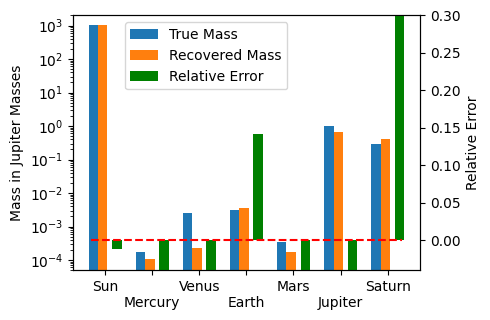

In [7]:
Names = ['Sun', '\nMercury', 'Venus', '\nEarth', 'Mars', '\nJupiter', 'Saturn', '\nApophis', 'Eros']

fig, ax1 = plt.subplots(figsize=(5,3.3))
xs = np.arange(7)
l1 = ax1.bar(xs-0.25, 10**dataset_data.params['masses_exp_10'][:7], width=0.2, label = 'True Mass')
# plt.plot(10**Result_int, label = 'Int')
l2 = ax1.bar(xs-0.05, 10**dataset_data.params_train['masses_exp_10'][:7], width=0.2, label = 'Recovered Mass')
# ax1.legend()
ax1.set_xticks(range(7))
ax1.set_xticklabels(Names[:7])
ax1.set_yscale('log')
ax1.set_ylabel("Mass in Jupiter Masses")
ax1.set_ylim((0.5e-4, 2e3))


ax1b = ax1.twinx()
ax1b.hlines(0,-.3,6.3, color='red', linestyles='dashed')
l3 = ax1b.bar(xs+0.25, 10**(dataset_data.params_train['masses_exp_10']-dataset_data.params['masses_exp_10'])[:7]-1, width=0.2, color='green', label = 'Relative Error')
#ax1b.legend()
ax1b.set_ylabel("Relative Error")
ax1b.set_ylim((-0.04,0.3))

ax1.legend(handles = [l1, l2, l3], bbox_to_anchor=(0.13, 1))
plt.tight_layout()
plt.show()

#### Long trainig for more accurate results

In [8]:
# First round of training, reset every 30 steps

N_sys = 1

reset_every = 30
kwargs_sys = {'N_sys':N_sys, 'N_bodies':ys_from_data['positions'].shape[2]}
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals_data)-1)/reset_every)))])

initial_guess_params = {'masses_exp_10':np.array([3.0,-4,-4,-4,-4,0,0,-6,-6])}
upper_params_boundary = {'masses_exp_10':np.array([4, 4, 4, 4, 4, 4, 4, -6, -6])}
lower_params_boundary = {'masses_exp_10':np.array([-4, -4, -4, -4, -4,-4,-4, -6, -6])}

kwargs_adoptODE = {'lr':0.03, 'lr_decay':0.9985, 'epochs':10000, 't_reset_idcs':t_reset_idcs, 'atol':1e-8, 'rtol':1e-8, 'upper_b':upper_params_boundary, 'lower_b':lower_params_boundary}#'lr_decay':0.999, 'epochs':6000
dataset_data = dataset_adoptODE(define_n_body, ys_from_data, t_evals_data, kwargs_sys, kwargs_adoptODE, params_train=initial_guess_params, true_params=true_params)

params_final, losses, errors, params_history = train_adoptODE(dataset_data, print_interval=500)

Epoch 000:   Params Err.: 2.2e+00, y0 error: nan, Params Norm: 1.2e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 3.5e+03, 
Epoch 500:   Params Err.: 1.1e+00, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 4.0e+01, 
Epoch 1000:   Params Err.: 8.2e-01, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.0e+00, 
Epoch 1500:   Params Err.: 6.5e-01, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.9e-01, 
Epoch 2000:   Params Err.: 5.1e-01, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.3e-01, 
Epoch 2500:   Params Err.: 3.9e-01, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.1e-01, 
Epoch 3000:   Params Err.: 3.0e-01, y0 error: nan, Params Norm: 1.1e+01, iParams Err.: 0.0

In [ ]:
# Second round of training, reset every 40 steps

N_sys = 1
reset_every = 40
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals_data)-1)/reset_every)))])
kwargs_adoptODE = {'lr':0.0003, 'lr_decay':0.997, 'epochs':2000, 't_reset_idcs':t_reset_idcs, 'atol':1e-9, 'rtol':1e-9, 'upper_b':upper_params_boundary, 'lower_b':lower_params_boundary}

# Generate a new dataset, but use the result of the last training period as initial guess:
dataset_data = dataset_adoptODE(define_n_body, ys_from_data, t_evals_data, kwargs_sys, kwargs_adoptODE, params_train=dataset_data.params_train, true_params=true_params)
params_final, losses, errors, params_history = train_adoptODE(dataset_data, print_interval=150)
print("Final params: ", dataset_data.params_train)

In [ ]:
Names = ['Sun', '\nMercury', 'Venus', '\nEarth', 'Mars', '\nJupiter', 'Saturn', '\nApophis', 'Eros']

fig, ax1 = plt.subplots(figsize=(5,3.3))
xs = np.arange(7)
l1 = ax1.bar(xs-0.25, 10**dataset_data.params['masses_exp_10'][:7], width=0.2, label = 'True Mass')
# plt.plot(10**Result_int, label = 'Int')
l2 = ax1.bar(xs-0.05, 10**dataset_data.params_train['masses_exp_10'][:7], width=0.2, label = 'Recovered Mass')
# ax1.legend()
ax1.set_xticks(range(7))
ax1.set_xticklabels(Names[:7])
ax1.set_yscale('log')
ax1.set_ylabel("Mass in Jupiter Masses")
ax1.set_ylim((0.5e-4, 2e3))


ax1b = ax1.twinx()
ax1b.hlines(0,-.3,6.3, color='red', linestyles='dashed')
l3 = ax1b.bar(xs+0.25, 10**(dataset_data.params_train['masses_exp_10']-dataset_data.params['masses_exp_10'])[:7]-1, width=0.2, color='green', label = 'Relative Error')
#ax1b.legend()
ax1b.set_ylabel("Relative Error")
ax1b.set_ylim((-0.04,0.3))

ax1.legend(handles = [l1, l2, l3], bbox_to_anchor=(0.13, 1))
plt.tight_layout()
plt.show()